In [79]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# comp-linguistics
import scipy
import spacy
import en_core_web_sm
import nltk

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qmun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97715 sha256=724a4e053bdc38c61798e69485f4683a5d38016c59d222d0a5eda0333b8de860
  Stored in directory: C:\Users\qmun\AppData\Local\pip\Cache\wheels\98\71\24\513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32045 sha256=47f3d69a2d11fc5298bcbaa6dd862f55e442f6a60f173f10e4b014cf93fec320
  Stored in directory: C:\Users\qmun\AppData\Local\pip\Cache\wheels\20\5a\d8\1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


### Loading and Cleaning the data

In [54]:
df = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_review.csv")
df_meta = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_meta.csv")
df.head()

,Unnamed: 0,asin,title,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,1,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,2,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN
3,3,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 15, 2018",A2FMMCFQ8702DN,{'Style:': ' Business'},Wickenball,Love it.,Five Stars,1526342400,NaN
4,4,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,5.0,NaN,True,"05 12, 2018",A1I8WBJSZIPJE0,{'Style:': ' Business'},B. Stearn,I've had various versions of this keyboard for...,Five Stars,1526083200,NaN


In [55]:
tbl = df.groupby('asin').agg({'overall':'count'})
tbl = tbl.sort_values(by = ['overall'], ascending = False)
tbl['asin'] = tbl.index
tbl = tbl.rename_axis("ID")
tbl

,overall,asin
ID,,
B000A6PPOK,2567,B000A6PPOK
B00I0S6SK0,1805,B00I0S6SK0
B00E4TOWR0,418,B00E4TOWR0
B00LSGKEC4,378,B00LSGKEC4
B0194MC7JG,343,B0194MC7JG


In [56]:
# downsampling
df_sample = df[df['asin'] == tbl.index[-1]]
for i in range(4):
    df_temp = df[df['asin'] == tbl.index[i]].sample(n=350)
    df_sample = df_sample.append(df_temp)
df_sample.shape

(1743, 14)

In [57]:
df_sample = df_sample[df_sample['reviewText'].notnull()]
df_agg = df.groupby(['asin', 'title'], as_index=False)[['reviewText']].agg(sum)
df_agg

,asin,title,reviewText
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach..."
1,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...
2,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....
3,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive..."
4,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...


In [58]:
df_agg['tokenized_words'] = df_agg['reviewText'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_agg['normalized_words'] = df_agg['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [59]:
df_agg

,asin,title,reviewText,tokenized_words,normalized_words
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach...","[As, a, software, developer, I, am, literally,...","[software, developer, literally, attached, key..."
1,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...,"[Love, it, The, keys, are, placed, where, I, l...","[love, keys, placed, like, bethis, keyboard, f..."
2,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....,"[This, is, just, what, I, needed, and, it, wor...","[needed, works, great, lights, great, night, l..."
3,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive...","[This, would, have, been, five, stars, but, I,...","[stars, received, bad, keyboard, initially, fu..."
4,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."


### HW5:Topic Extraction

First, we find the optimal number of topic number

In [74]:
def compute_corpus(data):
    
    #Functions to perform lemmatize and stem preprocessing steps
    def lemmatize_stemming(text):
        return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

    def preprocess(text):
        result = []
        for token in gensim.utils.simple_preprocess(text):
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                result.append(lemmatize_stemming(token))
        return result

    processed_docs = data.map(preprocess)
    #Bag of words & Filter out infrequent tokens
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below = 10, no_above = 0.5, keep_n = 100000)
    
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
        
    #TF-IDF (frequency-inverse document frequency): how important a word is to a document in a collection or corpus
    tfidf = models.TfidfModel(bow_corpus)
    corpus = tfidf[bow_corpus]
    
    return processed_docs, corpus, dictionary

In [80]:
processed_rev, corpus_rev, dictionary_rev = compute_corpus(df['reviewText'])

In [81]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    log_perplexity_values: log prplexity values to the LDA model with respective number of topics
    """
    
    coherence_values = []
    log_perplexity_values = []
    model_list = []
    
    #Iterate through different number of topics
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics, 
                                                id2word=dictionary, 
                                                random_state=100,
                                                chunksize = 100,
                                                passes = 10,
                                                alpha = 'auto')
        
        model_list.append(model)
        
        # Compute Coherence Score
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        
        
        coherence_values.append(coherencemodel.get_coherence())
        
        # Compute Perplexity
        log_perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, log_perplexity_values

In [82]:
limit = 10; start = 2; step = 1;

model_list, coherence_values, log_perplexity = compute_coherence_values(dictionary=dictionary_rev,
                                                                        corpus=corpus_rev, 
                                                                        texts=processed_rev, 
                                                                        start=2, 
                                                                        limit=limit, 
                                                                        step=1)

Text(0.5, 1.0, 'Topic Log Perplexity: Determining Optimal Number of Topics')

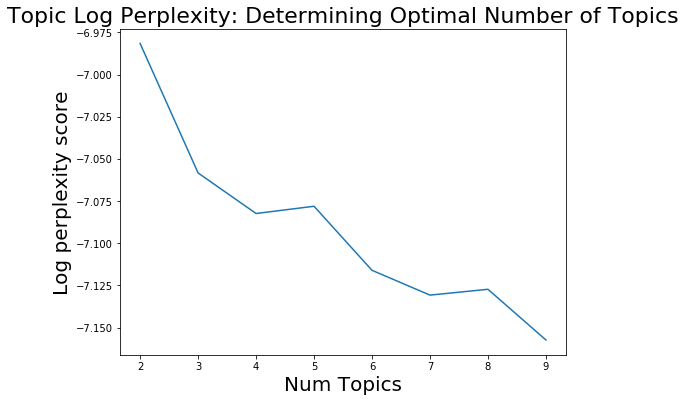

In [86]:
x = np.arange(start, limit, step)
plt.figure(figsize = (8,6))
plt.plot(x, log_perplexity)
plt.xlabel("Num Topics", fontsize=20)
plt.ylabel("Log perplexity score", fontsize=20)
plt.title('Topic Log Perplexity: Determining Optimal Number of Topics', fontsize=22)
#plt.savefig("Plots/perplexity.png")

Text(0.5, 1.0, 'Topic Coherence Score: Determining Optimal Number of Topics')

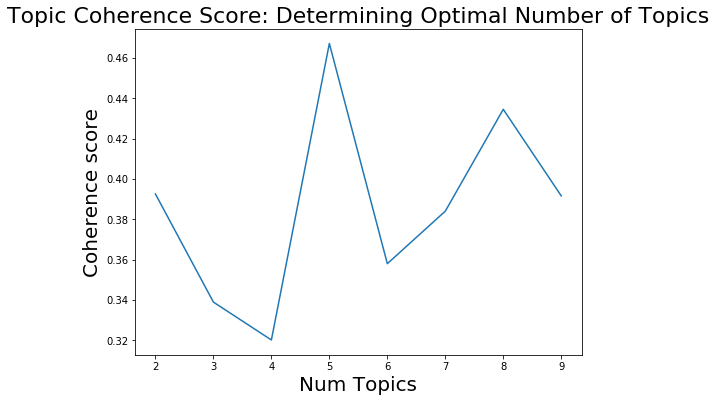

In [87]:
x = np.arange(start, limit, step)
plt.figure(figsize = (8,6))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics", fontsize=20)
plt.ylabel("Coherence score", fontsize=20)
plt.title('Topic Coherence Score: Determining Optimal Number of Topics', fontsize=22)
#plt.savefig("Plots/coherence.png")

Hence, we find the optimal model number = 5

## Model Building

Note, because of unsupervised machine learning, this graph as well as topic generation result might differ in each time running the data.

In [60]:
dictionary = gensim.corpora.Dictionary(df_agg['normalized_words'])

In [61]:
corpus = [dictionary.doc2bow(text) for text in df_agg['normalized_words']]

In [62]:
gensim.corpora.MmCorpus.serialize('amazon.mm', corpus)
senmm = gensim.corpora.MmCorpus('amazon.mm')

In [63]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=5, alpha='auto', eta='auto')

In [64]:
sen1Bow = dictionary.doc2bow(df_agg['normalized_words'][0])
sen1lda = senlda[sen1Bow]
sen1lda

[(0, 0.7259853), (1, 0.14416687), (2, 0.12482532)]

In [65]:
sen1Bow = dictionary.doc2bow(df_agg['normalized_words'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(df_agg['asin'][0]))
print("are: {}".format(sen1lda))

The topics of the text: B000A6PPOK
are: [(0, 0.7039467), (1, 0.16576648), (2, 0.12534474)]


In [66]:
ldaDF = pd.DataFrame({
        'name' : df_agg['asin'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in df_agg['normalized_words']]
    })

In [67]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4
0,B000A6PPOK,"[(0, 0.7099225), (1, 0.15651846), (2, 0.1272455)]",0.709922,0.156518,0.127246,0,0.000000
1,B00E4TOWR0,"[(0, 0.3580524), (1, 0.035607513), (2, 0.59111...",0.358052,0.035608,0.591115,0,0.015137
2,B00I0S6SK0,"[(0, 0.9818699), (1, 0.013911496)]",0.981870,0.013911,0.000000,0,0.000000
3,B00LSGKEC4,"[(0, 0.8634463), (1, 0.027392676), (4, 0.10355...",0.863446,0.027393,0.000000,0,0.103558
4,B0194MC7JG,"[(0, 0.19285919), (1, 0.030350512), (4, 0.7713...",0.192859,0.030351,0.000000,0,0.771379


In [68]:
ldaDFV = ldaDF[['topic_%d' %x for x in range(5)]]
ldaDFVisN = ldaDF[['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4
0,0.709922,0.156518,0.127246,0,0.000000
1,0.358052,0.035608,0.591115,0,0.015137
2,0.981870,0.013911,0.000000,0,0.000000
3,0.863446,0.027393,0.000000,0,0.103558
4,0.192859,0.030351,0.000000,0,0.771379


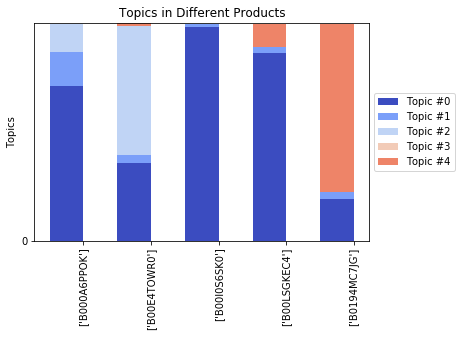

In [69]:
N = 5
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Different Products')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 5))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

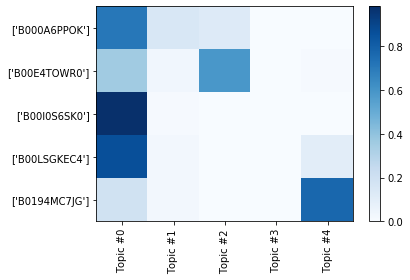

In [70]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [71]:
senlda.show_topic(1)

[('keyboard', 0.04693107),
 ('keys', 0.02356731),
 ('use', 0.012605322),
 ('like', 0.010255632),
 ('key', 0.008388727),
 ('great', 0.00745605),
 ('work', 0.007344124),
 ('keyboards', 0.007180412),
 ('time', 0.0063405046),
 ('good', 0.006007033)]

In [72]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,keyboard,keyboard,keyboard,keyboard,keyboard
1,keys,keys,keys,keys,keys
2,key,use,key,like,use
3,great,like,use,keyboards,like
4,use,key,like,key,key
5,like,great,keyboards,use,great
6,good,work,great,great,typing
7,work,keyboards,work,work,type
8,keyboards,time,typing,type,keyboards
9,typing,good,good,love,love


We can see a great number of overlapping between different reviews among different topics, which quite make sense since different reviewers might have similar comments on the similar keyboards product.